In [1]:
from v2x import V2XData
from tsai.all import *

In [4]:
files_path = './data/Sejong'
v2xdata = V2XData(files_path, hazard_thr=3)


loaded 46 files
['./data/Sejong\\0901_5RNBVU80.csv', './data/Sejong\\0901_OKG5RJW0.csv', './data/Sejong\\0902_5RNBVU80.csv', './data/Sejong\\0902_9CU6AVIU.csv', './data/Sejong\\0903_5RNBVU80.csv'] ...


df[2] shape: (10459, 11)
X      - shape: [1045 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1045,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [522, 523]  overlap: False


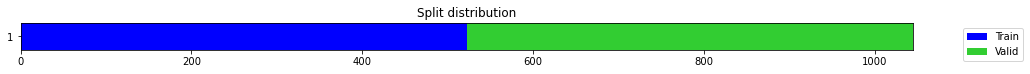

files index: 0 ~ 46


100%|██████████| 46/46 [00:14<00:00,  3.26it/s]

X_sum shape: (35300, 9, 10), y_sum shape: (35300,)
X      - shape: [35300 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (35300,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [17650, 17650]  overlap: False


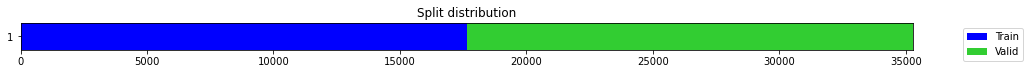

In [8]:
X, y, splits, df = v2xdata[2]
check_data(X, y, splits=splits)
X_all, y_all, splits, df_all = v2xdata.get_all_item()
check_data(X_all, y_all, splits=splits)

In [7]:
df.head(3)

,HEADING,SPEED,HAZARDLIGHTS_FLAG,HARDBRAKING_FLAG,LIGHTSCHANGE_FLAG,HARDDECELERATION_FLAG,UTURN_FLAG,LIGHTS_STATUS,CURRENT_LANE,scene,Hazard
0,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False
1,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False
2,-1.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scene_3,False


In [47]:
for col in df_all.columns:
    ignore_col = ['HEADING', 'SPEED', 'X', 'Y', 'scene', 'Hazard']
    if col in ignore_col:
        continue
    print(f'{col}: {df_all[col].unique()}')

HAZARDLIGHTS_FLAG: [ 0.  1. -1.  2. -2.]
HARDBRAKING_FLAG: [ 0.  1. -1.  2. -2.]
LIGHTSCHANGE_FLAG: [ 0.  1. -1.  2. -2.]
HARDDECELERATION_FLAG: [ 0.  1. -1.]
UTURN_FLAG: [ 0.  1. -1.]
LIGHTS_STATUS: [  0.   4.   8.  -4.  -8.  16. -16. -12.  12.  28. -28. -20.  24. -24.
  20.]
CURRENT_LANE: [ 0.  4. -4.  3.  2. -3. -2. -1.  1. -5.  6. -6.  5. -7.  7.  8.]


In [76]:
def learn_model(X, y, splits, model_input, epochs):
    # train with LSTM
    tfms = [TSStandardize(verbose=True), [Categorize()]]
    batch_tfms = TSStandardize(by_sample=True)
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=batch_tfms)
    dls.show_batch()

    model = create_model(model_input, dls = dls)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(epochs, 1e-3)
    learn.plot_metrics()
    
def multivariate_classification(X, y, splits, epochs=20, model=LSTM, lr = 1e-3, metrics=accuracy, lr_find=False, load_ckpt = False):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    # X, y, splits = get_classification_data('LSST', split_data=False)
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=256, batch_tfms=batch_tfms)
    batch_tfms = TSStandardize(by_sample=True)
    
    m = create_model(model, dls = dls)
    learn = Learner(dls, m, metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    learn.save('classification')
    return learn
    
def minirocket_classification(X, y, splits, epochs=20, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False):
    tfms = [None, [TSClassification()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_sample=True)
    dls = get_ts_dls(X, y, bs=256, tfms=tfms, batch_tfms=batch_tfms, splits=splits)
    
    m = create_model(model, dls = dls)
    learn = ts_learner(dls, m, kernel_size=len(X[0]), metrics=metrics)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    learn.save('rocket')
    return learn

def multivariate_forecasting(X, y, splits, epochs=20, model=LSTM, lr = 1e-3, metrics=mae, lr_find=False):
    "model_input: LSTM, LSTMPlus, MLSTM_Plus, LSTM_FCN"
    splits = TSSplitter()(y)
    tfms = [None, [TSRegression()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    batch_tfms = TSStandardize(by_var=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    
    m = create_model(model, dls = dls)
    learn = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, arch=None, arch_config=dict(fc_dropout=.2), metrics=metrics, bs=512,
                         partial_n=.1, train_metrics=True)
    if lr_find:
        learn.lr_find()
    learn.fit(epochs, lr)
    learn.recorder.plot_metrics()
    learn.save('forecasting')
    return learn

In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import sklearn.metrics as skm

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # f1 score
    print(f'오차행렬 : \n{confusion}\n\nTN = {confusion[0, 0]}, FP = {confusion[0, 1]}\nFN = {confusion[1, 0]}, TP = {confusion[1, 1]}\n')
    print(f'정확도 : {round(accuracy, 4)} \n정밀도 : {round(precision, 4)} \n재현율 : {round(recall, 4)} \nF1 score : {round(f1, 4)}')

# inference

loaded 3 files
['./data/1-Cycle\\0926_821OJMMY.csv', './data/1-Cycle\\0926_MCPSLU1U.csv', './data/1-Cycle\\0926_OHGY9ZSV.csv'] ...


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

X_sum shape: (2546, 9, 10), y_sum shape: (2546,)
Dataset Info is...
X shape: (2546, 9, 10), y shape: (2546,)
splits: (train: (#1273)(0, ...)) (test: (#1273)(1273, ...))
# True in y: (array([0, 1]), array([2219,  327], dtype=int64))
Dataset Info is done.
X      - shape: [2546 samples x 9 features x 10 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (2546,)  type: ndarray  dtype:int32  isnan: 0
splits - n_splits: 2 shape: [1273, 1273]  overlap: False


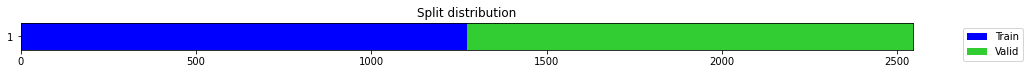

In [97]:
inf_path = './data/1-Cycle'

v2xdata = V2XData(inf_path, hazard_thr=3)
X, y, splits, df = v2xdata.get_all_item()
v2xdata.get_data_info(X, y, splits)

check_data(X, y, splits=splits)

In [130]:
tfms = [None, [Categorize()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X, y, tfms=tfms)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
model = create_model(MLSTM_FCNPlus, dls = dls)
learner = Learner(dls, model, metrics=accuracy)
learner.load('model')

In [135]:
# load model
learner = load_learner_all(path='models', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learner.dls
valid_dl = dls.valid

# add Labelled test data
test_ds = valid_dl.dataset.add_test(X, y) # test data
test_dl = valid_dl.new(test_ds)
test_probas, test_targets, test_preds = learner.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'precision: {skm.precision_score(test_targets, test_preds):10.6f}')
print(f'recall: {skm.recall_score(test_targets, test_preds):10.6f}')
print(f'f1: {skm.f1_score(test_targets, test_preds):10.6f}')

# compare on table
test_preds_tensor = torch.tensor(test_preds)
compare_table = pd.DataFrame([test_targets, test_preds_tensor]).T

accuracy:   0.927337
precision:   0.955128
recall:   0.455657
f1:   0.616977
TensorBase(0.9273)


TensorBase(0.9207)


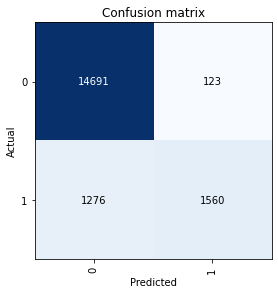

In [86]:
print((valid_targets == valid_preds).float().mean())
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

# end inference

epoch,train_loss,valid_loss,accuracy,time
0,2.074216,3.687134,0.111111,00:02
1,1.649432,2.281937,0.189781,00:02
2,1.362581,1.479431,0.528792,00:02
3,1.154527,1.228426,0.599757,00:02
4,0.991463,1.085312,0.637064,00:02
5,0.860411,1.063518,0.662612,00:02
6,0.751722,1.110025,0.650852,00:02
7,0.657632,1.061910,0.669505,00:02
8,0.575983,1.050900,0.669505,00:02
9,0.504939,1.119205,0.667883,00:02


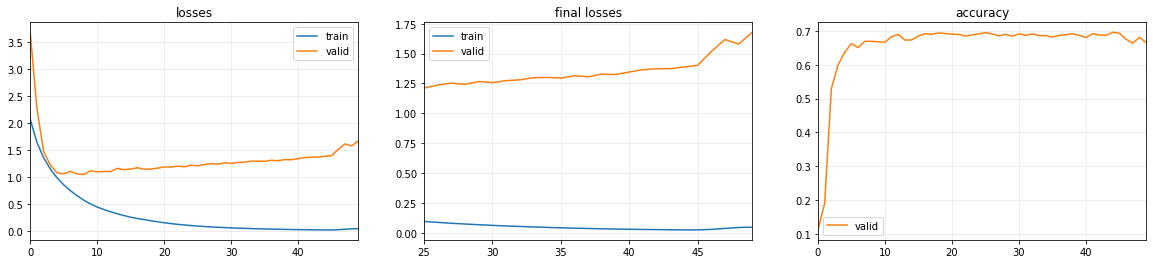

In [54]:
minirocket_classification(X, y, splits, epochs=50, model=MiniRocketPlus, lr = 1e-3, metrics=accuracy, lr_find=False)

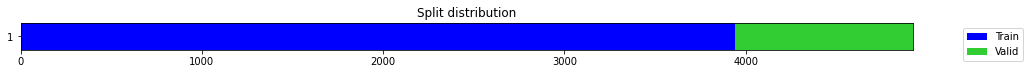

epoch,train_loss,train_mae,valid_loss,valid_mae,time
0,4035.176270,57.598530,8170.714844,90.389160,00:00
1,3939.350830,55.636570,8094.535645,89.966507,00:00


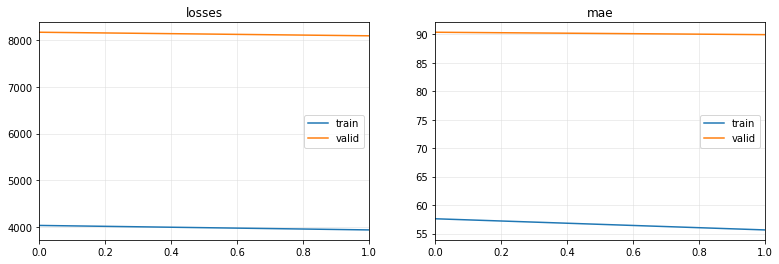

In [33]:
multivariate_forecasting(X_all, y_all, splits, epochs=2, model=LSTM, lr = 1e-3, lr_find=False)

epoch,train_loss,valid_loss,accuracy,time
0,0.432675,0.441605,0.839320,00:12
1,0.430753,0.449352,0.839320,00:12
2,0.437304,0.440245,0.839320,00:12
3,0.434644,0.439650,0.839320,00:13
4,0.434895,0.437565,0.839320,00:12
5,0.442021,0.438089,0.839320,00:11
6,0.445418,0.443110,0.839320,00:12
7,0.428667,0.437968,0.839320,00:12
8,0.435748,0.438133,0.839320,00:12
9,0.427722,0.436942,0.839320,00:10


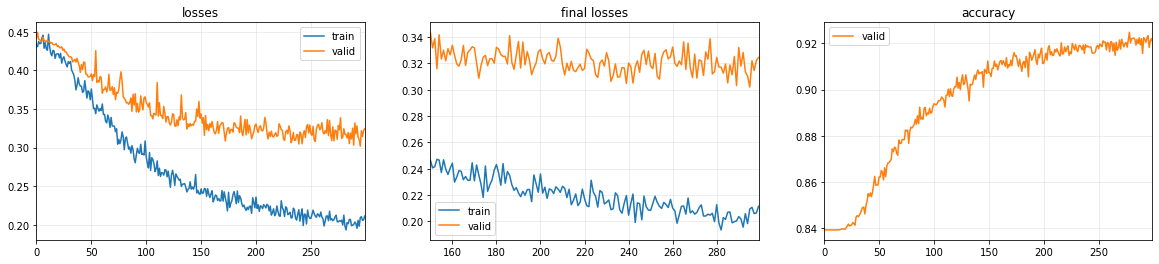

In [61]:
multivariate_classification(X_all, y_all, splits, epochs=300, model=MLSTM_FCNPlus, lr = 1e-3, metrics=accuracy)

# TS Classification

epoch,train_loss,valid_loss,accuracy,time
0,0.610862,0.637526,0.789474,00:00
1,0.543891,0.588012,0.789474,00:00
2,0.480455,0.515660,0.789474,00:00
3,0.419447,0.551365,0.789474,00:00
4,0.367510,0.679785,0.789474,00:00
5,0.335073,0.668797,0.789474,00:00
6,0.310686,0.607035,0.789474,00:00
7,0.293726,0.631922,0.789474,00:00
8,0.279131,0.639701,0.789474,00:00
9,0.268276,0.642383,0.789474,00:00


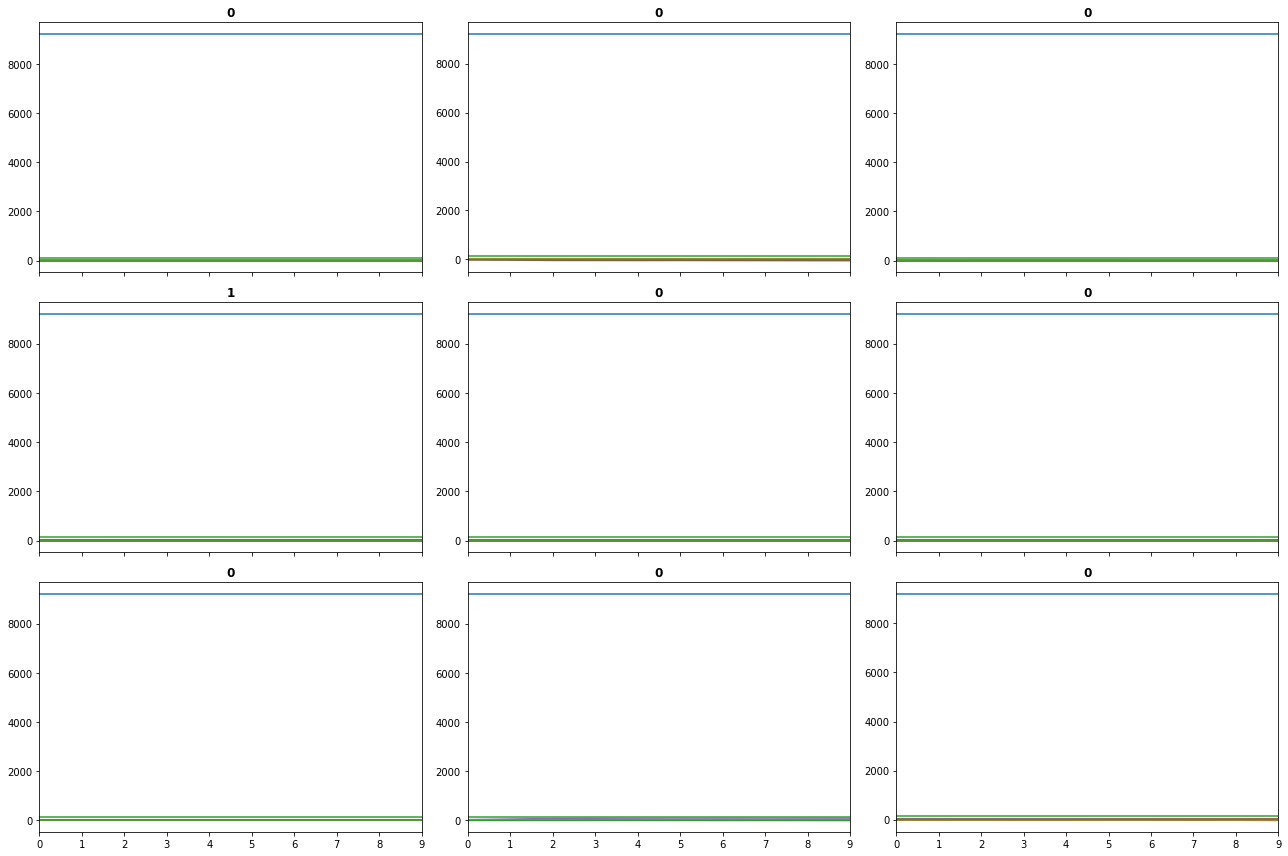

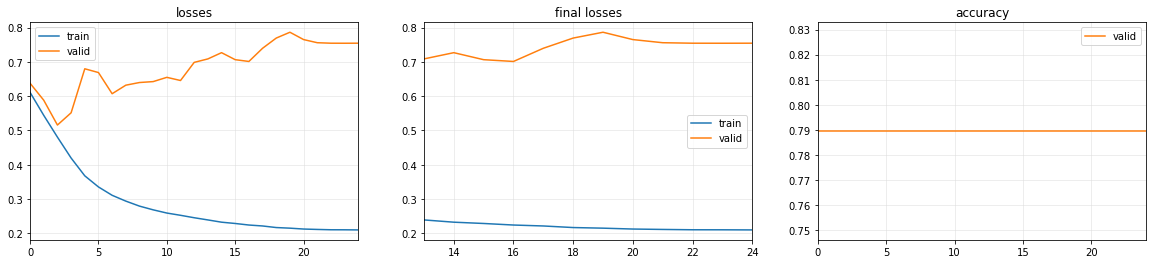

In [16]:
# train with LSTM
tfms = [TSStandardize(verbose=True), [Categorize()]]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=None)
dls.show_batch()

model = create_model(LSTM_FCN, dls = dls)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, 1e-3)
learn.plot_metrics()                                                                                 

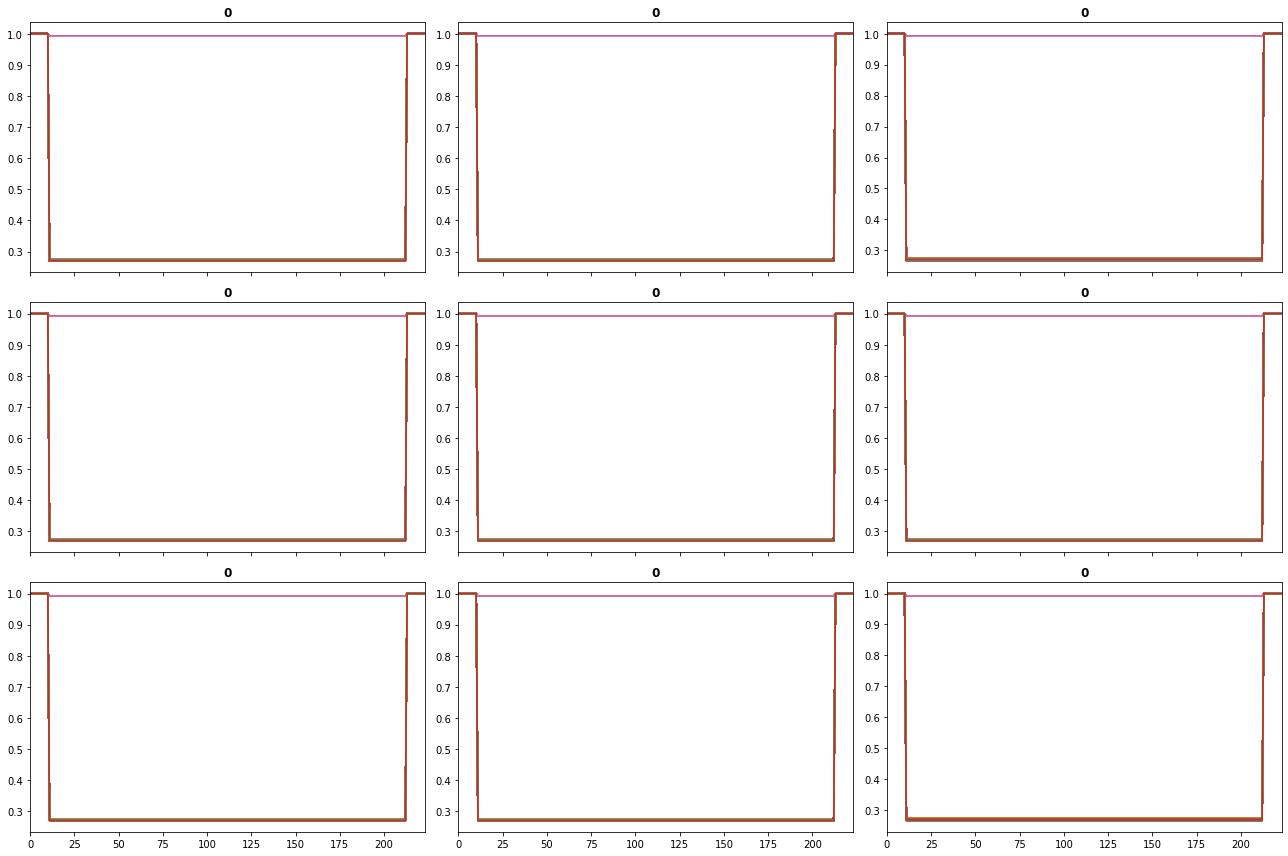

In [15]:
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToMat()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,0.529063,0.648135,0.789474,00:00
1,0.459778,0.666250,0.789474,00:00
2,0.411229,0.667061,0.789474,00:00
3,0.370723,0.639245,0.789474,00:00
4,0.341257,0.533517,0.789474,00:00
5,0.313532,0.534927,0.789474,00:00
6,0.292706,0.591950,0.789474,00:00
7,0.277813,0.636862,0.789474,00:00
8,0.266816,0.742299,0.789474,00:00
9,0.256933,0.916653,0.789474,00:00



training time: 00:00:43


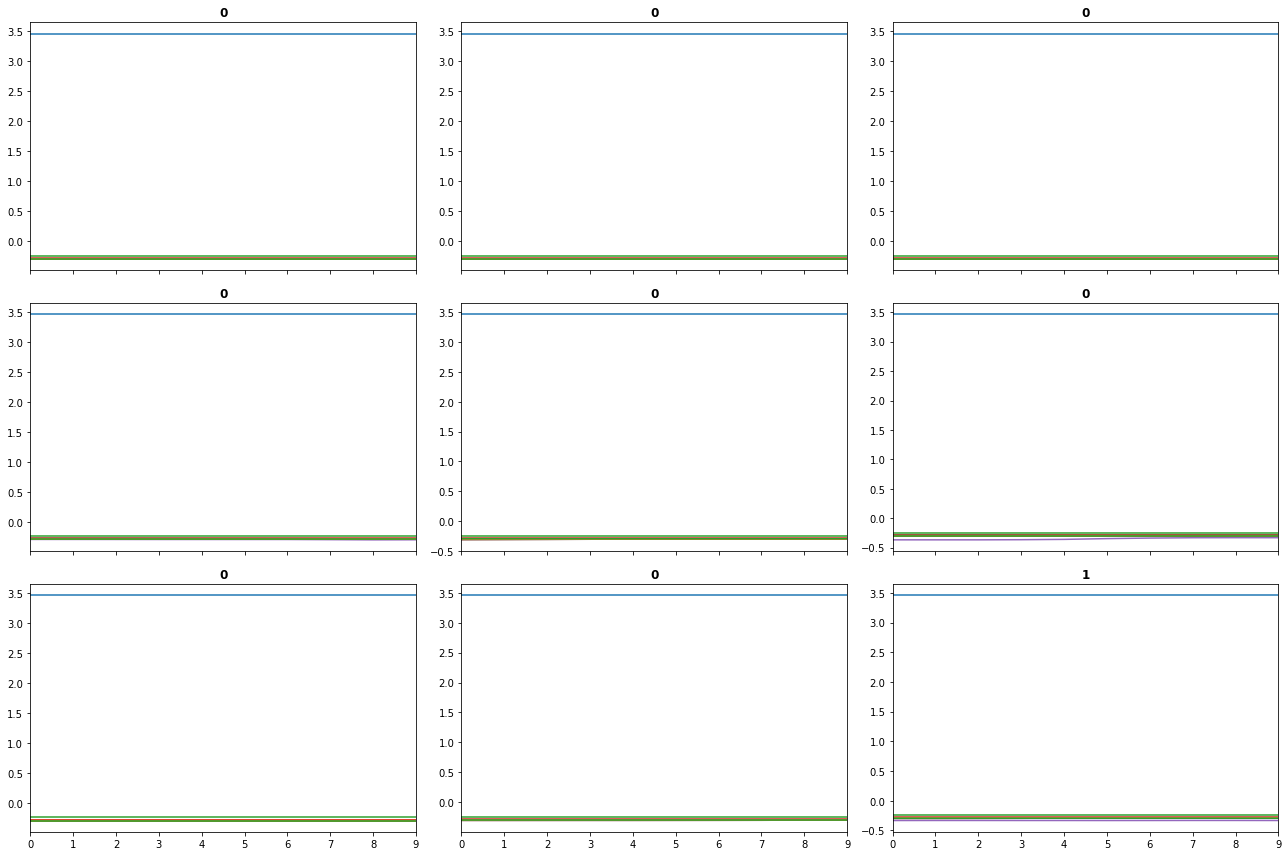

In [76]:
tfms = [None, Categorize()]
batch_tfms = [TSStandardize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
dls.show_batch()

model = create_model(InceptionTime, dls=dls)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(epochs, lr_max=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")